#Import

In [2]:
import pandas as pd
import numpy as np
from google.colab import drive

from sklearn.neighbors import KNeighborsClassifier
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
import seaborn as sns
import math
import tensorflow as tf
import os

from tensorflow import keras
from tensorflow.keras import layers, Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.optimizers import Adam
from keras.models import load_model

In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


#Menampilkan Data

In [4]:
missing_values = ['8888']

In [5]:
df = pd.read_excel('/content/drive/MyDrive/Dataset/Dataset_Curah_Hujan.xlsx', na_values = missing_values)
df

,Tanggal,RR
0,01-01-2019,NaN
1,02-01-2019,0.0
2,03-01-2019,20.5
3,04-01-2019,2.6
4,05-01-2019,0.9
...,...,...
1699,27-08-2023,0.0
1700,28-08-2023,0.0
1701,29-08-2023,0.0
1702,30-08-2023,0.0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1704 entries, 0 to 1703
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Tanggal  1704 non-null   object 
 1   RR       1426 non-null   float64
dtypes: float64(1), object(1)
memory usage: 26.8+ KB


In [7]:
df['Tanggal'] = pd.to_datetime(df['Tanggal'], format='%d-%m-%Y')

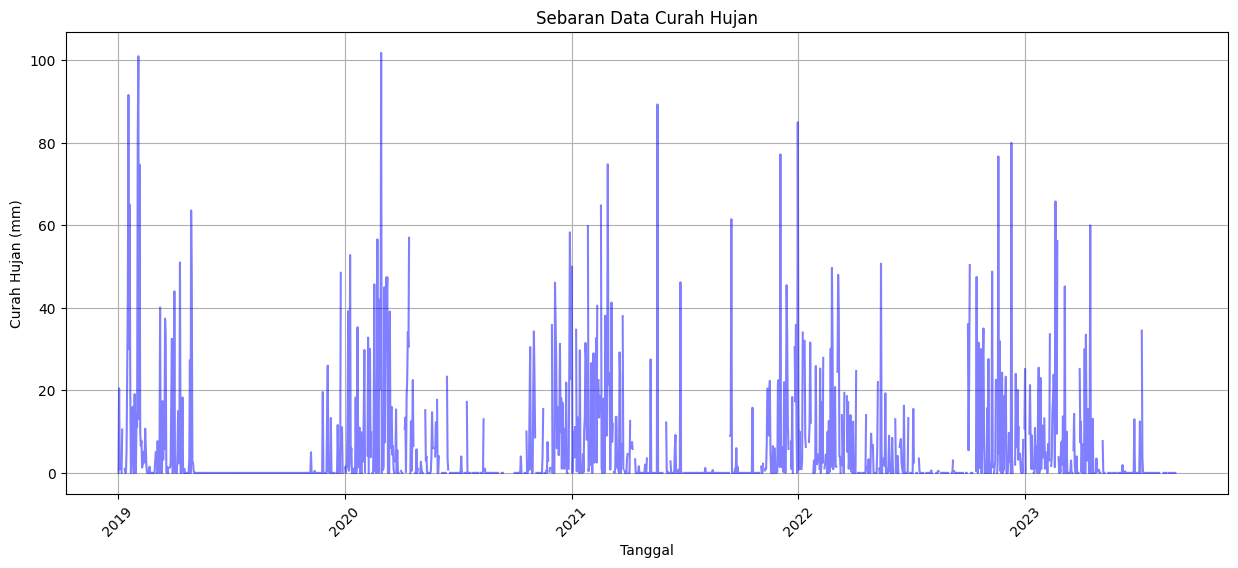

In [8]:
import matplotlib.pyplot as plt


# Plot scatter plot
plt.figure(figsize=(15, 6))
plt.plot(df['Tanggal'], df['RR'], linestyle='-', color='blue', alpha=0.5)
plt.title('Sebaran Data Curah Hujan')
plt.xlabel('Tanggal')
plt.ylabel('Curah Hujan (mm)')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

#Pre-processing Data

##Penanganan Missing Value

In [23]:
df.isnull().sum()

Tanggal      0
RR         278
dtype: int64

In [24]:
# Daftar nilai parameter yang ingin dicoba
epoch_list = [12, 25, 50]
learning_rate_list = [0.01, 0.001, 0.0001]
time_step_list = [25, 50, 75]
#split_data_list = [0.5, 0.6, 0.7, 0.8, 0.9]

# Fungsi untuk membangun dan melatih model LSTM
def build_and_train_lstm(x_train, y_train, x_test, y_test, epochs, learning_rate):
    model = keras.Sequential()
    model.add(layers.LSTM(100, return_sequences=True, input_shape=(x_train.shape[1], 1)))
    model.add(layers.LSTM(100, return_sequences=False))
    model.add(layers.Dense(25))
    model.add(layers.Dense(1))
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    history = model.fit(x_train, y_train, batch_size=32, epochs=epochs, verbose=1)
    predictions = model.predict(x_test)
    predictions = scaler.inverse_transform(predictions)
    rmse = np.sqrt(np.mean(predictions - y_test)**2)
    return model, rmse

# Membuat folder untuk menyimpan hasil
if not os.path.exists('results'):
    os.makedirs('results')

# Loop melalui kombinasi parameter
results = []
skenario = 1

# Hapus data
df = df.dropna(subset=['RR'])
data = pd.DataFrame(df['RR'])

# Simpan data yang diimputasi
data_hapus = f'results/hapus_data.csv'
data.to_csv(data_hapus, index=False)

# Normalisasi data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data[['RR']])
scaled_data_df = pd.DataFrame(scaled_data)

# Simpan data yang dinormalisasi
normalisasi_file = f'results/normalisasi.csv'
scaled_data_df.to_csv(normalisasi_file, index=False)

for epochs in epoch_list:
  for learning_rate in learning_rate_list:
    for time_steps in time_step_list:
      # Pembagian data
      values = scaled_data_df.values
      training_data_len = math.ceil(len(values) * 0.7)
      train_data = scaled_data[0:training_data_len, :]

      x_train = []
      y_train = []

      for i in range(time_steps, len(train_data)):
        x_train.append(train_data[i-time_steps:i, 0])
        y_train.append(train_data[i, 0])

      x_train, y_train = np.array(x_train), np.array(y_train)
      x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

      test_data = scaled_data[training_data_len-time_steps:, :]
      x_test = []
      y_test = values[training_data_len:]

      for i in range(time_steps, len(test_data)):
        x_test.append(test_data[i-time_steps:i, 0])

      x_test = np.array(x_test)
      x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

      # Menyimpan data train dan data testing
      x_train_df = pd.DataFrame({'x_train': x_train.flatten()})
      x_train_file = f'results/xtrain_epochs_{epochs}_lr_{learning_rate}_ts_{time_steps}.csv'
      x_train_df.to_csv(x_train_file, index=False)

      y_train_df = pd.DataFrame({'y_train': y_train.flatten()})
      y_train_file = f'results/ytrain_epochs_{epochs}_lr_{learning_rate}_ts_{time_steps}.csv'
      y_train_df.to_csv(y_train_file, index=False)

      x_test_df = pd.DataFrame({'x_test': x_test.flatten()})
      x_test_file = f'results/xtest_epochs_{epochs}_lr_{learning_rate}_ts_{time_steps}.csv'
      x_test_df.to_csv(x_test_file, index=False)

      y_test_df = pd.DataFrame({'y_test': y_test.flatten()})
      y_test_file = f'results/ytest_epochs_{epochs}_lr_{learning_rate}_ts_{time_steps}.csv'
      y_test_df.to_csv(y_test_file, index=False)

      # Train and evaluate LSTM model
      model, rmse = build_and_train_lstm(x_train, y_train, x_test, y_test, epochs, learning_rate)

      # Simpan model
      model_file = f'results/model_epochs_{epochs}_lr_{learning_rate}_ts_{time_steps}.h5'
      model.save(model_file)

      # Simpan hasil evaluasi
      results.append([skenario, epochs, learning_rate, time_steps, rmse])

      # Print hasil evaluasi
      print(f'Skenario ke-{skenario} : epochs={epochs}, learning_rate={learning_rate}, time_steps={time_steps}, RMSE={rmse}')
      skenario += 1

# Simpan semua hasil evaluasi ke CSV
results_df = pd.DataFrame(results, columns=['skenario', 'epochs', 'learning_rate', 'time_steps', 'RMSE'])
results_df.to_csv('results/all_results.csv', index=False)

Epoch 1/12
31/31 [==============================] - 5s 49ms/step - loss: 0.0212
Epoch 2/12
31/31 [==============================] - 2s 65ms/step - loss: 0.0162
Epoch 3/12
31/31 [==============================] - 2s 62ms/step - loss: 0.0161
Epoch 4/12
31/31 [==============================] - 2s 64ms/step - loss: 0.0167
Epoch 5/12
31/31 [==============================] - 1s 42ms/step - loss: 0.0162
Epoch 6/12
31/31 [==============================] - 1s 42ms/step - loss: 0.0159
Epoch 7/12
31/31 [==============================] - 1s 45ms/step - loss: 0.0155
Epoch 8/12
31/31 [==============================] - 1s 45ms/step - loss: 0.0153
Epoch 9/12
31/31 [==============================] - 1s 40ms/step - loss: 0.0156
Epoch 10/12
31/31 [==============================] - 1s 40ms/step - loss: 0.0156
Epoch 11/12
31/31 [==============================] - 1s 39ms/step - loss: 0.0155
Epoch 12/12
14/14 [==============================] - 1s 14ms/step
Skenario ke-1 : epochs=12, learning_rate=0.01, time_

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/12
30/30 [==============================] - 6s 80ms/step - loss: 0.0225
Epoch 2/12
30/30 [==============================] - 2s 76ms/step - loss: 0.0149
Epoch 3/12
30/30 [==============================] - 3s 113ms/step - loss: 0.0146
Epoch 4/12
30/30 [==============================] - 3s 104ms/step - loss: 0.0157
Epoch 5/12
30/30 [==============================] - 2s 78ms/step - loss: 0.0149
Epoch 6/12
30/30 [==============================] - 2s 75ms/step - loss: 0.0150
Epoch 7/12
30/30 [==============================] - 2s 70ms/step - loss: 0.0141
Epoch 8/12
30/30 [==============================] - 2s 71ms/step - loss: 0.0151
Epoch 9/12
30/30 [==============================] - 3s 103ms/step - loss: 0.0144
Epoch 10/12
30/30 [==============================] - 3s 108ms/step - loss: 0.0143
Epoch 11/12
30/30 [==============================] - 2s 72ms/step - loss: 0.0149
Epoch 12/12
14/14 [==============================] - 1s 26ms/step
Skenario ke-2 : epochs=12, learning_rate=0.01, t

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/12
29/29 [==============================] - 7s 107ms/step - loss: 0.0209
Epoch 2/12
29/29 [==============================] - 5s 157ms/step - loss: 0.0152
Epoch 3/12
29/29 [==============================] - 5s 170ms/step - loss: 0.0148
Epoch 4/12
29/29 [==============================] - 3s 111ms/step - loss: 0.0145
Epoch 5/12
29/29 [==============================] - 3s 120ms/step - loss: 0.0144
Epoch 6/12
29/29 [==============================] - 4s 154ms/step - loss: 0.0142
Epoch 7/12
29/29 [==============================] - 3s 102ms/step - loss: 0.0145
Epoch 8/12
29/29 [==============================] - 4s 134ms/step - loss: 0.0143
Epoch 9/12
29/29 [==============================] - 5s 157ms/step - loss: 0.0142
Epoch 10/12
29/29 [==============================] - 4s 134ms/step - loss: 0.0145
Epoch 11/12
29/29 [==============================] - 3s 98ms/step - loss: 0.0145
Epoch 12/12
14/14 [==============================] - 1s 34ms/step
Skenario ke-3 : epochs=12, learning_rate=0

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/12
31/31 [==============================] - 7s 60ms/step - loss: 0.0165
Epoch 2/12
31/31 [==============================] - 2s 52ms/step - loss: 0.0162
Epoch 3/12
31/31 [==============================] - 1s 43ms/step - loss: 0.0158
Epoch 4/12
31/31 [==============================] - 1s 40ms/step - loss: 0.0158
Epoch 5/12
31/31 [==============================] - 1s 38ms/step - loss: 0.0157
Epoch 6/12
31/31 [==============================] - 1s 38ms/step - loss: 0.0155
Epoch 7/12
31/31 [==============================] - 2s 63ms/step - loss: 0.0155
Epoch 8/12
31/31 [==============================] - 2s 52ms/step - loss: 0.0155
Epoch 9/12
31/31 [==============================] - 2s 49ms/step - loss: 0.0152
Epoch 10/12
31/31 [==============================] - 2s 61ms/step - loss: 0.0153
Epoch 11/12
31/31 [==============================] - 2s 61ms/step - loss: 0.0152
Epoch 12/12
14/14 [==============================] - 1s 13ms/step
Skenario ke-4 : epochs=12, learning_rate=0.001, time

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/12
30/30 [==============================] - 8s 91ms/step - loss: 0.0151
Epoch 2/12
30/30 [==============================] - 3s 115ms/step - loss: 0.0143
Epoch 3/12
30/30 [==============================] - 3s 89ms/step - loss: 0.0142
Epoch 4/12
30/30 [==============================] - 3s 84ms/step - loss: 0.0141
Epoch 5/12
30/30 [==============================] - 2s 81ms/step - loss: 0.0142
Epoch 6/12
30/30 [==============================] - 2s 77ms/step - loss: 0.0143
Epoch 7/12
30/30 [==============================] - 3s 108ms/step - loss: 0.0144
Epoch 8/12
30/30 [==============================] - 3s 106ms/step - loss: 0.0142
Epoch 9/12
30/30 [==============================] - 2s 82ms/step - loss: 0.0145
Epoch 10/12
30/30 [==============================] - 3s 84ms/step - loss: 0.0144
Epoch 11/12
30/30 [==============================] - 2s 77ms/step - loss: 0.0141
Epoch 12/12
14/14 [==============================] - 2s 34ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Skenario ke-5 : epochs=12, learning_rate=0.001, time_steps=50, RMSE=4.625003494513344
Epoch 1/12
29/29 [==============================] - 7s 109ms/step - loss: 0.0152
Epoch 2/12
29/29 [==============================] - 3s 107ms/step - loss: 0.0143
Epoch 3/12
29/29 [==============================] - 4s 153ms/step - loss: 0.0143
Epoch 4/12
29/29 [==============================] - 4s 131ms/step - loss: 0.0145
Epoch 5/12
29/29 [==============================] - 3s 105ms/step - loss: 0.0142
Epoch 6/12
29/29 [==============================] - 3s 105ms/step - loss: 0.0142
Epoch 7/12
29/29 [==============================] - 4s 134ms/step - loss: 0.0143
Epoch 8/12
29/29 [==============================] - 4s 147ms/step - loss: 0.0141
Epoch 9/12
29/29 [==============================] - 3s 118ms/step - loss: 0.0141
Epoch 10/12
29/29 [==============================] - 3s 108ms/step - loss: 0.0140
Epoch 11/12
29/29 [==============================] - 3s 113ms/step - loss: 0.0142
Epoch 12/12
14/14 [==

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/12
31/31 [==============================] - 5s 39ms/step - loss: 0.0170
Epoch 2/12
31/31 [==============================] - 1s 38ms/step - loss: 0.0158
Epoch 3/12
31/31 [==============================] - 1s 38ms/step - loss: 0.0157
Epoch 4/12
31/31 [==============================] - 2s 59ms/step - loss: 0.0156
Epoch 5/12
31/31 [==============================] - 2s 66ms/step - loss: 0.0157
Epoch 6/12
31/31 [==============================] - 2s 62ms/step - loss: 0.0156
Epoch 7/12
31/31 [==============================] - 2s 55ms/step - loss: 0.0157
Epoch 8/12
31/31 [==============================] - 1s 42ms/step - loss: 0.0157
Epoch 9/12
31/31 [==============================] - 1s 42ms/step - loss: 0.0157
Epoch 10/12
31/31 [==============================] - 1s 38ms/step - loss: 0.0156
Epoch 11/12
31/31 [==============================] - 1s 39ms/step - loss: 0.0155
Epoch 12/12
14/14 [==============================] - 1s 18ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Skenario ke-7 : epochs=12, learning_rate=0.0001, time_steps=25, RMSE=5.013196303392687
Epoch 1/12
30/30 [==============================] - 7s 70ms/step - loss: 0.0152
Epoch 2/12
30/30 [==============================] - 2s 74ms/step - loss: 0.0143
Epoch 3/12
30/30 [==============================] - 2s 77ms/step - loss: 0.0141
Epoch 4/12
30/30 [==============================] - 3s 87ms/step - loss: 0.0142
Epoch 5/12
30/30 [==============================] - 3s 112ms/step - loss: 0.0143
Epoch 6/12
30/30 [==============================] - 3s 88ms/step - loss: 0.0142
Epoch 7/12
30/30 [==============================] - 2s 79ms/step - loss: 0.0141
Epoch 8/12
30/30 [==============================] - 2s 78ms/step - loss: 0.0141
Epoch 9/12
30/30 [==============================] - 2s 72ms/step - loss: 0.0141
Epoch 10/12
30/30 [==============================] - 2s 74ms/step - loss: 0.0141
Epoch 11/12
30/30 [==============================] - 3s 106ms/step - loss: 0.0141
Epoch 12/12
14/14 [==========

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Skenario ke-8 : epochs=12, learning_rate=0.0001, time_steps=50, RMSE=4.359941429394416
Epoch 1/12
29/29 [==============================] - 7s 100ms/step - loss: 0.0160
Epoch 2/12
29/29 [==============================] - 3s 113ms/step - loss: 0.0144
Epoch 3/12
29/29 [==============================] - 5s 162ms/step - loss: 0.0141
Epoch 4/12
29/29 [==============================] - 3s 104ms/step - loss: 0.0141
Epoch 5/12
29/29 [==============================] - 3s 103ms/step - loss: 0.0141
Epoch 6/12
29/29 [==============================] - 3s 100ms/step - loss: 0.0140
Epoch 7/12
29/29 [==============================] - 4s 141ms/step - loss: 0.0141
Epoch 8/12
29/29 [==============================] - 4s 147ms/step - loss: 0.0141
Epoch 9/12
29/29 [==============================] - 3s 106ms/step - loss: 0.0140
Epoch 10/12
29/29 [==============================] - 3s 104ms/step - loss: 0.0141
Epoch 11/12
29/29 [==============================] - 3s 101ms/step - loss: 0.0140
Epoch 12/12
14/14 [=

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/25
31/31 [==============================] - 6s 37ms/step - loss: 0.0268
Epoch 2/25
31/31 [==============================] - 2s 55ms/step - loss: 0.0159
Epoch 3/25
31/31 [==============================] - 2s 61ms/step - loss: 0.0161
Epoch 4/25
31/31 [==============================] - 2s 60ms/step - loss: 0.0162
Epoch 5/25
31/31 [==============================] - 1s 46ms/step - loss: 0.0156
Epoch 6/25
31/31 [==============================] - 1s 41ms/step - loss: 0.0162
Epoch 7/25
31/31 [==============================] - 1s 37ms/step - loss: 0.0158
Epoch 8/25
31/31 [==============================] - 1s 37ms/step - loss: 0.0158
Epoch 9/25
31/31 [==============================] - 1s 38ms/step - loss: 0.0160
Epoch 10/25
31/31 [==============================] - 1s 42ms/step - loss: 0.0154
Epoch 11/25
31/31 [==============================] - 1s 40ms/step - loss: 0.0156
Epoch 12/25
31/31 [==============================] - 1s 40ms/step - loss: 0.0165
Epoch 13/25
31/31 [==================

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/25
30/30 [==============================] - 8s 123ms/step - loss: 0.0268
Epoch 2/25
30/30 [==============================] - 3s 96ms/step - loss: 0.0150
Epoch 3/25
30/30 [==============================] - 2s 80ms/step - loss: 0.0159
Epoch 4/25
30/30 [==============================] - 2s 79ms/step - loss: 0.0145
Epoch 5/25
30/30 [==============================] - 2s 79ms/step - loss: 0.0146
Epoch 6/25
30/30 [==============================] - 3s 98ms/step - loss: 0.0143
Epoch 7/25
30/30 [==============================] - 3s 113ms/step - loss: 0.0151
Epoch 8/25
30/30 [==============================] - 2s 79ms/step - loss: 0.0142
Epoch 9/25
30/30 [==============================] - 2s 79ms/step - loss: 0.0142
Epoch 10/25
30/30 [==============================] - 2s 79ms/step - loss: 0.0148
Epoch 11/25
30/30 [==============================] - 2s 79ms/step - loss: 0.0150
Epoch 12/25
30/30 [==============================] - 3s 109ms/step - loss: 0.0140
Epoch 13/25
30/30 [===============

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/25
29/29 [==============================] - 8s 154ms/step - loss: 0.0369
Epoch 2/25
29/29 [==============================] - 4s 121ms/step - loss: 0.0149
Epoch 3/25
29/29 [==============================] - 3s 107ms/step - loss: 0.0142
Epoch 4/25
29/29 [==============================] - 3s 106ms/step - loss: 0.0143
Epoch 5/25
29/29 [==============================] - 4s 133ms/step - loss: 0.0150
Epoch 6/25
29/29 [==============================] - 4s 139ms/step - loss: 0.0143
Epoch 7/25
29/29 [==============================] - 3s 106ms/step - loss: 0.0140
Epoch 8/25
29/29 [==============================] - 3s 107ms/step - loss: 0.0152
Epoch 9/25
29/29 [==============================] - 3s 114ms/step - loss: 0.0148
Epoch 10/25
29/29 [==============================] - 5s 156ms/step - loss: 0.0143
Epoch 11/25
29/29 [==============================] - 3s 107ms/step - loss: 0.0143
Epoch 12/25
29/29 [==============================] - 3s 107ms/step - loss: 0.0139
Epoch 13/25
29/29 [======

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/25
31/31 [==============================] - 7s 57ms/step - loss: 0.0161
Epoch 2/25
31/31 [==============================] - 1s 39ms/step - loss: 0.0157
Epoch 3/25
31/31 [==============================] - 1s 41ms/step - loss: 0.0159
Epoch 4/25
31/31 [==============================] - 1s 40ms/step - loss: 0.0156
Epoch 5/25
31/31 [==============================] - 1s 40ms/step - loss: 0.0155
Epoch 6/25
31/31 [==============================] - 1s 40ms/step - loss: 0.0154
Epoch 7/25
31/31 [==============================] - 1s 40ms/step - loss: 0.0154
Epoch 8/25
31/31 [==============================] - 1s 40ms/step - loss: 0.0154
Epoch 9/25
31/31 [==============================] - 1s 42ms/step - loss: 0.0156
Epoch 10/25
31/31 [==============================] - 2s 60ms/step - loss: 0.0153
Epoch 11/25
31/31 [==============================] - 2s 61ms/step - loss: 0.0155
Epoch 12/25
31/31 [==============================] - 2s 52ms/step - loss: 0.0155
Epoch 13/25
31/31 [==================

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/25
30/30 [==============================] - 7s 94ms/step - loss: 0.0150
Epoch 2/25
30/30 [==============================] - 3s 107ms/step - loss: 0.0142
Epoch 3/25
30/30 [==============================] - 2s 71ms/step - loss: 0.0144
Epoch 4/25
30/30 [==============================] - 2s 71ms/step - loss: 0.0142
Epoch 5/25
30/30 [==============================] - 2s 72ms/step - loss: 0.0142
Epoch 6/25
30/30 [==============================] - 2s 71ms/step - loss: 0.0143
Epoch 7/25
30/30 [==============================] - 3s 85ms/step - loss: 0.0142
Epoch 8/25
30/30 [==============================] - 3s 110ms/step - loss: 0.0142
Epoch 9/25
30/30 [==============================] - 2s 76ms/step - loss: 0.0140
Epoch 10/25
30/30 [==============================] - 2s 71ms/step - loss: 0.0141
Epoch 11/25
30/30 [==============================] - 2s 74ms/step - loss: 0.0140
Epoch 12/25
30/30 [==============================] - 2s 72ms/step - loss: 0.0141
Epoch 13/25
30/30 [================

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Skenario ke-14 : epochs=25, learning_rate=0.001, time_steps=50, RMSE=6.610217077425494
Epoch 1/25
29/29 [==============================] - 8s 153ms/step - loss: 0.0148
Epoch 2/25
29/29 [==============================] - 3s 103ms/step - loss: 0.0145
Epoch 3/25
29/29 [==============================] - 3s 99ms/step - loss: 0.0143
Epoch 4/25
29/29 [==============================] - 3s 99ms/step - loss: 0.0145
Epoch 5/25
29/29 [==============================] - 4s 124ms/step - loss: 0.0145
Epoch 6/25
29/29 [==============================] - 4s 136ms/step - loss: 0.0142
Epoch 7/25
29/29 [==============================] - 3s 99ms/step - loss: 0.0142
Epoch 8/25
29/29 [==============================] - 3s 99ms/step - loss: 0.0142
Epoch 9/25
29/29 [==============================] - 3s 100ms/step - loss: 0.0141
Epoch 10/25
29/29 [==============================] - 4s 152ms/step - loss: 0.0141
Epoch 11/25
29/29 [==============================] - 3s 117ms/step - loss: 0.0140
Epoch 12/25
29/29 [=====

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/25
31/31 [==============================] - 7s 38ms/step - loss: 0.0173
Epoch 2/25
31/31 [==============================] - 1s 38ms/step - loss: 0.0161
Epoch 3/25
31/31 [==============================] - 1s 38ms/step - loss: 0.0159
Epoch 4/25
31/31 [==============================] - 1s 39ms/step - loss: 0.0158
Epoch 5/25
31/31 [==============================] - 1s 37ms/step - loss: 0.0157
Epoch 6/25
31/31 [==============================] - 1s 37ms/step - loss: 0.0158
Epoch 7/25
31/31 [==============================] - 1s 39ms/step - loss: 0.0156
Epoch 8/25
31/31 [==============================] - 1s 38ms/step - loss: 0.0156
Epoch 9/25
31/31 [==============================] - 2s 51ms/step - loss: 0.0156
Epoch 10/25
31/31 [==============================] - 2s 63ms/step - loss: 0.0156
Epoch 11/25
31/31 [==============================] - 2s 62ms/step - loss: 0.0156
Epoch 12/25
31/31 [==============================] - 1s 42ms/step - loss: 0.0155
Epoch 13/25
31/31 [==================

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/25
30/30 [==============================] - 14s 81ms/step - loss: 0.0159
Epoch 2/25
30/30 [==============================] - 2s 81ms/step - loss: 0.0143
Epoch 3/25
30/30 [==============================] - 4s 131ms/step - loss: 0.0141
Epoch 4/25
30/30 [==============================] - 4s 147ms/step - loss: 0.0141
Epoch 5/25
30/30 [==============================] - 4s 135ms/step - loss: 0.0141
Epoch 6/25
30/30 [==============================] - 3s 103ms/step - loss: 0.0140
Epoch 7/25
30/30 [==============================] - 3s 107ms/step - loss: 0.0142
Epoch 8/25
30/30 [==============================] - 5s 158ms/step - loss: 0.0141
Epoch 9/25
30/30 [==============================] - 3s 86ms/step - loss: 0.0141
Epoch 10/25
30/30 [==============================] - 2s 83ms/step - loss: 0.0141
Epoch 11/25
30/30 [==============================] - 4s 133ms/step - loss: 0.0140
Epoch 12/25
30/30 [==============================] - 5s 169ms/step - loss: 0.0141
Epoch 13/25
30/30 [=========

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/25
29/29 [==============================] - 8s 106ms/step - loss: 0.0153
Epoch 2/25
29/29 [==============================] - 3s 105ms/step - loss: 0.0142
Epoch 3/25
29/29 [==============================] - 3s 119ms/step - loss: 0.0142
Epoch 4/25
29/29 [==============================] - 5s 156ms/step - loss: 0.0142
Epoch 5/25
29/29 [==============================] - 3s 107ms/step - loss: 0.0141
Epoch 6/25
29/29 [==============================] - 3s 107ms/step - loss: 0.0141
Epoch 7/25
29/29 [==============================] - 3s 106ms/step - loss: 0.0142
Epoch 8/25
29/29 [==============================] - 4s 155ms/step - loss: 0.0141
Epoch 9/25
29/29 [==============================] - 3s 115ms/step - loss: 0.0141
Epoch 10/25
29/29 [==============================] - 3s 107ms/step - loss: 0.0141
Epoch 11/25
29/29 [==============================] - 4s 126ms/step - loss: 0.0143
Epoch 12/25
29/29 [==============================] - 4s 150ms/step - loss: 0.0141
Epoch 13/25
29/29 [======

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/50
31/31 [==============================] - 5s 40ms/step - loss: 0.0205
Epoch 2/50
31/31 [==============================] - 1s 40ms/step - loss: 0.0168
Epoch 3/50
31/31 [==============================] - 1s 40ms/step - loss: 0.0162
Epoch 4/50
31/31 [==============================] - 2s 53ms/step - loss: 0.0161
Epoch 5/50
31/31 [==============================] - 2s 60ms/step - loss: 0.0157
Epoch 6/50
31/31 [==============================] - 2s 63ms/step - loss: 0.0161
Epoch 7/50
31/31 [==============================] - 1s 43ms/step - loss: 0.0164
Epoch 8/50
31/31 [==============================] - 1s 40ms/step - loss: 0.0162
Epoch 9/50
31/31 [==============================] - 1s 40ms/step - loss: 0.0159
Epoch 10/50
31/31 [==============================] - 1s 40ms/step - loss: 0.0156
Epoch 11/50
31/31 [==============================] - 1s 40ms/step - loss: 0.0168
Epoch 12/50
31/31 [==============================] - 1s 40ms/step - loss: 0.0159
Epoch 13/50
31/31 [==================

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/50
30/30 [==============================] - 6s 71ms/step - loss: 0.0209
Epoch 2/50
30/30 [==============================] - 3s 105ms/step - loss: 0.0147
Epoch 3/50
30/30 [==============================] - 3s 94ms/step - loss: 0.0144
Epoch 4/50
30/30 [==============================] - 2s 71ms/step - loss: 0.0144
Epoch 5/50
30/30 [==============================] - 2s 72ms/step - loss: 0.0145
Epoch 6/50
30/30 [==============================] - 2s 71ms/step - loss: 0.0147
Epoch 7/50
30/30 [==============================] - 2s 71ms/step - loss: 0.0147
Epoch 8/50
30/30 [==============================] - 3s 99ms/step - loss: 0.0143
Epoch 9/50
30/30 [==============================] - 4s 120ms/step - loss: 0.0142
Epoch 10/50
30/30 [==============================] - 2s 72ms/step - loss: 0.0145
Epoch 11/50
30/30 [==============================] - 2s 72ms/step - loss: 0.0147
Epoch 12/50
30/30 [==============================] - 2s 71ms/step - loss: 0.0147
Epoch 13/50
30/30 [================

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/50
29/29 [==============================] - 8s 134ms/step - loss: 0.0217
Epoch 2/50
29/29 [==============================] - 4s 131ms/step - loss: 0.0146
Epoch 3/50
29/29 [==============================] - 3s 100ms/step - loss: 0.0146
Epoch 4/50
29/29 [==============================] - 3s 101ms/step - loss: 0.0159
Epoch 5/50
29/29 [==============================] - 3s 100ms/step - loss: 0.0143
Epoch 6/50
29/29 [==============================] - 5s 158ms/step - loss: 0.0146
Epoch 7/50
29/29 [==============================] - 3s 105ms/step - loss: 0.0153
Epoch 8/50
29/29 [==============================] - 3s 112ms/step - loss: 0.0144
Epoch 9/50
29/29 [==============================] - 5s 159ms/step - loss: 0.0151
Epoch 10/50
29/29 [==============================] - 5s 155ms/step - loss: 0.0147
Epoch 11/50
29/29 [==============================] - 3s 108ms/step - loss: 0.0146
Epoch 12/50
29/29 [==============================] - 3s 99ms/step - loss: 0.0143
Epoch 13/50
29/29 [=======

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/50
31/31 [==============================] - 6s 59ms/step - loss: 0.0165
Epoch 2/50
31/31 [==============================] - 2s 61ms/step - loss: 0.0158
Epoch 3/50
31/31 [==============================] - 1s 41ms/step - loss: 0.0156
Epoch 4/50
31/31 [==============================] - 1s 37ms/step - loss: 0.0158
Epoch 5/50
31/31 [==============================] - 1s 37ms/step - loss: 0.0155
Epoch 6/50
31/31 [==============================] - 1s 38ms/step - loss: 0.0155
Epoch 7/50
31/31 [==============================] - 1s 40ms/step - loss: 0.0155
Epoch 8/50
31/31 [==============================] - 1s 38ms/step - loss: 0.0154
Epoch 9/50
31/31 [==============================] - 1s 38ms/step - loss: 0.0153
Epoch 10/50
31/31 [==============================] - 1s 37ms/step - loss: 0.0153
Epoch 11/50
31/31 [==============================] - 1s 44ms/step - loss: 0.0153
Epoch 12/50
31/31 [==============================] - 2s 60ms/step - loss: 0.0154
Epoch 13/50
31/31 [==================

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/50
30/30 [==============================] - 6s 76ms/step - loss: 0.0146
Epoch 2/50
30/30 [==============================] - 3s 107ms/step - loss: 0.0144
Epoch 3/50
30/30 [==============================] - 3s 86ms/step - loss: 0.0143
Epoch 4/50
30/30 [==============================] - 2s 70ms/step - loss: 0.0142
Epoch 5/50
30/30 [==============================] - 2s 70ms/step - loss: 0.0142
Epoch 6/50
30/30 [==============================] - 2s 69ms/step - loss: 0.0142
Epoch 7/50
30/30 [==============================] - 2s 70ms/step - loss: 0.0143
Epoch 8/50
30/30 [==============================] - 3s 98ms/step - loss: 0.0141
Epoch 9/50
30/30 [==============================] - 3s 98ms/step - loss: 0.0140
Epoch 10/50
30/30 [==============================] - 2s 69ms/step - loss: 0.0142
Epoch 11/50
30/30 [==============================] - 2s 69ms/step - loss: 0.0142
Epoch 12/50
30/30 [==============================] - 2s 69ms/step - loss: 0.0139
Epoch 13/50
30/30 [=================

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/50
29/29 [==============================] - 8s 110ms/step - loss: 0.0153
Epoch 2/50
29/29 [==============================] - 3s 97ms/step - loss: 0.0146
Epoch 3/50
29/29 [==============================] - 3s 97ms/step - loss: 0.0142
Epoch 4/50
29/29 [==============================] - 3s 110ms/step - loss: 0.0147
Epoch 5/50
29/29 [==============================] - 4s 152ms/step - loss: 0.0143
Epoch 6/50
29/29 [==============================] - 3s 97ms/step - loss: 0.0142
Epoch 7/50
29/29 [==============================] - 3s 97ms/step - loss: 0.0142
Epoch 8/50
29/29 [==============================] - 3s 96ms/step - loss: 0.0140
Epoch 9/50
29/29 [==============================] - 4s 125ms/step - loss: 0.0141
Epoch 10/50
29/29 [==============================] - 4s 139ms/step - loss: 0.0139
Epoch 11/50
29/29 [==============================] - 3s 97ms/step - loss: 0.0140
Epoch 12/50
29/29 [==============================] - 3s 103ms/step - loss: 0.0139
Epoch 13/50
29/29 [============

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/50
31/31 [==============================] - 5s 44ms/step - loss: 0.0180
Epoch 2/50
31/31 [==============================] - 1s 45ms/step - loss: 0.0161
Epoch 3/50
31/31 [==============================] - 1s 45ms/step - loss: 0.0158
Epoch 4/50
31/31 [==============================] - 1s 45ms/step - loss: 0.0157
Epoch 5/50
31/31 [==============================] - 2s 62ms/step - loss: 0.0156
Epoch 6/50
31/31 [==============================] - 2s 63ms/step - loss: 0.0156
Epoch 7/50
31/31 [==============================] - 2s 59ms/step - loss: 0.0156
Epoch 8/50
31/31 [==============================] - 1s 44ms/step - loss: 0.0157
Epoch 9/50
31/31 [==============================] - 1s 44ms/step - loss: 0.0157
Epoch 10/50
31/31 [==============================] - 1s 47ms/step - loss: 0.0157
Epoch 11/50
31/31 [==============================] - 1s 44ms/step - loss: 0.0155
Epoch 12/50
31/31 [==============================] - 1s 45ms/step - loss: 0.0156
Epoch 13/50
31/31 [==================

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Skenario ke-25 : epochs=50, learning_rate=0.0001, time_steps=25, RMSE=5.648210691658006
Epoch 1/50
30/30 [==============================] - 8s 104ms/step - loss: 0.0158
Epoch 2/50
30/30 [==============================] - 2s 79ms/step - loss: 0.0143
Epoch 3/50
30/30 [==============================] - 2s 78ms/step - loss: 0.0142
Epoch 4/50
30/30 [==============================] - 2s 79ms/step - loss: 0.0141
Epoch 5/50
30/30 [==============================] - 2s 82ms/step - loss: 0.0141
Epoch 6/50
30/30 [==============================] - 3s 115ms/step - loss: 0.0141
Epoch 7/50
30/30 [==============================] - 3s 94ms/step - loss: 0.0141
Epoch 8/50
30/30 [==============================] - 2s 78ms/step - loss: 0.0141
Epoch 9/50
30/30 [==============================] - 2s 79ms/step - loss: 0.0141
Epoch 10/50
30/30 [==============================] - 2s 78ms/step - loss: 0.0140
Epoch 11/50
30/30 [==============================] - 3s 92ms/step - loss: 0.0140
Epoch 12/50
30/30 [=========

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/50
29/29 [==============================] - 8s 145ms/step - loss: 0.0169
Epoch 2/50
29/29 [==============================] - 4s 124ms/step - loss: 0.0146
Epoch 3/50
29/29 [==============================] - 3s 103ms/step - loss: 0.0142
Epoch 4/50
29/29 [==============================] - 3s 104ms/step - loss: 0.0141
Epoch 5/50
29/29 [==============================] - 3s 120ms/step - loss: 0.0141
Epoch 6/50
29/29 [==============================] - 4s 153ms/step - loss: 0.0142
Epoch 7/50
29/29 [==============================] - 3s 105ms/step - loss: 0.0142
Epoch 8/50
29/29 [==============================] - 3s 105ms/step - loss: 0.0141
Epoch 9/50
29/29 [==============================] - 3s 104ms/step - loss: 0.0140
Epoch 10/50
29/29 [==============================] - 4s 150ms/step - loss: 0.0140
Epoch 11/50
29/29 [==============================] - 3s 116ms/step - loss: 0.0140
Epoch 12/50
29/29 [==============================] - 3s 105ms/step - loss: 0.0141
Epoch 13/50
29/29 [======

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [25]:
df.isnull().sum()

Tanggal    0
RR         0
dtype: int64

In [27]:
import shutil
shutil.make_archive('hasil_hapus_data', 'zip', '/content/results')
from google.colab import files
files.download('hasil_hapus_data.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

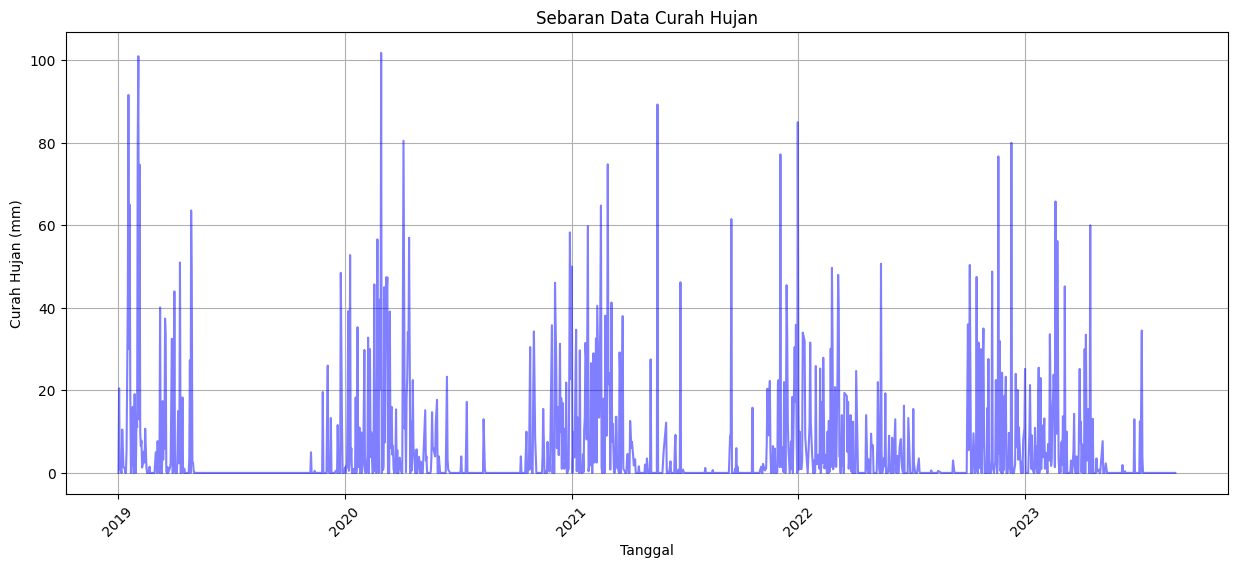

In [29]:
import matplotlib.pyplot as plt


# Plot scatter plot
plt.figure(figsize=(15, 6))
plt.plot(df['Tanggal'], df['RR'], linestyle='-', color='blue', alpha=0.5)
plt.title('Sebaran Data Curah Hujan')
plt.xlabel('Tanggal')
plt.ylabel('Curah Hujan (mm)')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

In [ ]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)
predictions = predictions.flatten()
rmse = np.sqrt(np.mean(predictions - y_test)**2)
rmse

14/14 [==============================] - 1s 15ms/step


0.21882776354180028

In [ ]:
# Membuat DataFrame
data_df = pd.DataFrame({
    'Tanggal': df['Tanggal'][999: ].values,
    'Curah_Hujan': df['RR'][999: ].values,
    'Prediksi_Curah_Hujan': predictions.flatten()  # Pastikan hasil prediksi memiliki dimensi satu
})
data_df

#Prediksi

In [31]:
n = 1  # Example: Predict the next 10 time steps
future_predictions = []
x_last_window = x_test[-25]  # Menggunakan bagian terakhir dari data testing sebagai x_last_window
last_window = x_last_window.reshape((1, x_last_window.shape[0], x_last_window.shape[1]))

for _ in range(n):
    # Predict the next time step
    prediction = model.predict(last_window)

    # Append the prediction to the list of future predictions
    future_predictions.append(prediction[0])

    # Update the last window by removing the first element and appending the prediction
    last_window = np.append(last_window[:, 1:, :], prediction.reshape(1, 1, 1), axis=1)

# Convert the list of future predictions to a numpy array
future_predictions = np.array(future_predictions)
print('future_predictions : ', future_predictions)

# Inverse transform predictions to get the original scale
future_predictions_denormalisasi = scaler.inverse_transform(future_predictions)
print('future_predictions_denormalisasi : ', future_predictions_denormalisasi)

1/1 [==============================] - 0s 39ms/step
future_predictions :  [[0.02348299]]
future_predictions_denormalisasi :  [[2.390568]]


In [ ]:
data = df.filter(['RR'])
train = data[:training_data_len]
validation = data[training_data_len:]
validation['Predictions'] = predictions
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Tanggal')
plt.ylabel('Curah Hujan (mm)')
plt.plot(train)
plt.plot(validation[['RR', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [ ]:
#Memvisualisasikan hasil prediksi
plt.figure(figsize=(20,7))
plt.plot(df['Tanggal'].values[999: ], values[999: ], color = 'blue', label = 'Curah Hujan')
plt.plot(df['Tanggal'][-predictions.shape[0]:].values, predictions, color = 'red', label = 'Prediksi Curah Hujan')
plt.title('Prediksi Curah Hujan')
plt.xlabel('Tanggal')
plt.ylabel('Curah Hujan (mm)')
plt.legend()
plt.show()

In [ ]:
# Save the model
model.save("model_lstm_hapusdata_s1.hdf5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
